In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.optimize import minimize

In [10]:
def generate_correlated_data(nUncorAssets, nObs, noiseVariance):
    uncorrelated_data = np.random.normal(0, 1, size=(nObs, nUncorAssets))
    cor_data = uncorrelated_data + np.random.normal(0, noiseVariance, size=(nObs, nUncorAssets))
    result = np.concatenate((uncorrelated_data, cor_data), axis=1)

    cols = ['X_' + str(i) for i in range(nUncorAssets)]
    cols.extend(['Cor_X_' + str(i) for i in range(nUncorAssets)])

    return pd.DataFrame(result, columns=cols)

In [11]:
nUncorAssets, nObs, noiseVariance = 10, 1000, 0.25
df = generate_correlated_data(nUncorAssets, nObs, noiseVariance)

In [12]:
def get_correlation_matrix(df):
    M, N = df.shape
    cor_mat = np.corrcoef(df.values.T)
    cor_mat = np.sqrt(0.5 * (1-cor_mat))
    return cor_mat

In [20]:
cor_mat = get_correlation_matrix(df)

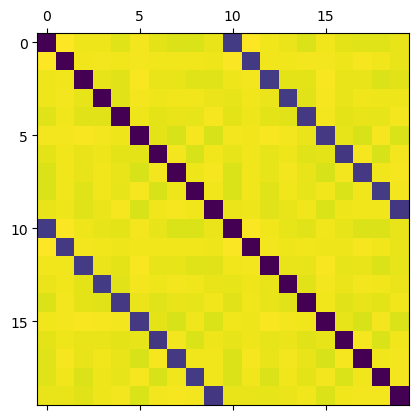

In [21]:
# Item i is positive correlated with item (i+10)
plt.matshow(cor_mat)

In [16]:
def get_distance_matrix(ndarray):
    N = ndarray.shape[0]
    dist_mat = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            dist_mat[i, j] = np.linalg.norm(ndarray[:,i] - ndarray[:,j])

    return dist_mat

In [17]:
dist_mat = get_distance_matrix(cor_mat)

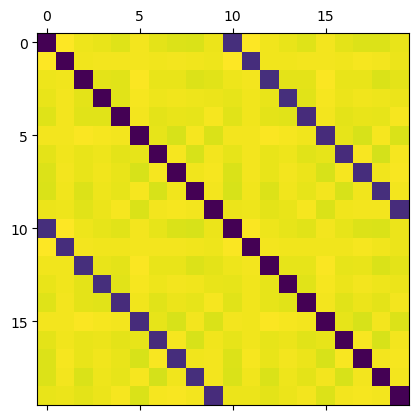

In [19]:
plt.matshow(dist_mat)

In [27]:
link = sch.linkage(dist_mat, 'single')

/var/folders/n9/wjwtm16d4yv_wm10tjxk3sjr0000gn/T/ipykernel_12223/1961048211.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist_mat, 'single')


In [71]:
def quasi_diag(link):
    sorted_idx_labels = sch.dendrogram(link)['ivl']
    return [int(idx_label) for idx_label in sorted_idx_labels]

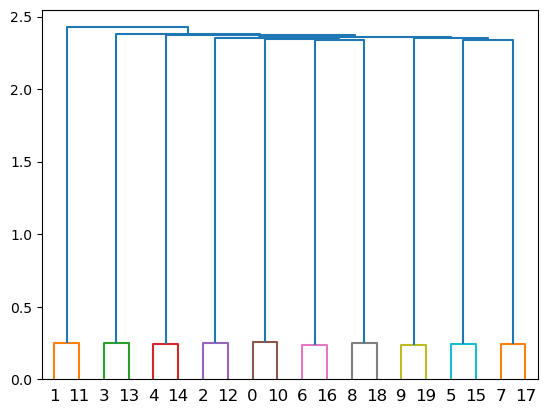

In [77]:
sorted_idx = quasi_diag(link)

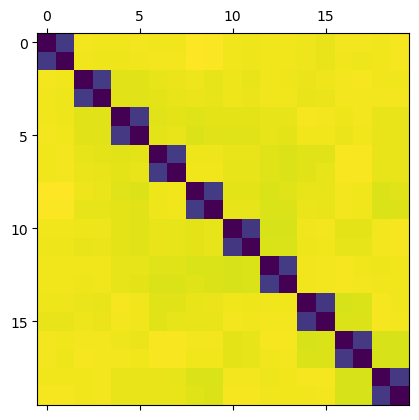

In [79]:
quasi_df = df.iloc[:, sorted_idx]
quasi_corr = get_correlation_matrix(quasi_df)
plt.matshow(quasi_corr)

#### Compute the HRP allocation

In [149]:
def get_ivp(cov: np.ndarray, **kargs) -> np.ndarray:
    '''
    Computes the inverse variance portfolio.
    
        Parameters:
            cov (np.ndarray): covariance matrix
            
        Returns:
            ivp (np.ndarray): optimal portfolio weights
    '''    
    ivp = 1.0 / np.diag(cov) ## vector
    ivp /= ivp.sum()
    return ivp

In [165]:
def get_cluster_var(cov: np.ndarray, cItems: np.ndarray) -> float:
    '''
    Computes the minimum variance per cluster using the weights from inverse variance portfolio.
    
        Parameters:
            cov (np.ndarray): covariance matrix for all items
            cItems (np.ndarray): indexes of cluster items
            
        Returns:
            cVar (float): cluster variance
    '''
    
    cov_ = cov[:, cItems][cItems]    # matrix slice
    w_ = get_ivp(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

In [170]:
def get_rec_bipart(cov: np.ndarray, sortIx: list) -> pd.Series:
    '''
    Computes Hierarchical Risk Parity allocation for a given subset of items.
    
        Parameters:
            cov (np.ndarray): covariance matrix
            sortIx (list): sorted items list
    '''
    w = pd.Series([1] * len(sortIx), index=sortIx)
    
    # A list of list of indexes
    cItems = [sortIx]    # initialize all items in one cluster
    while len(cItems) > 0:        
        cItems = [partition[int(half_part_start): int(half_part_end)] for partition in cItems
                  for half_part_start, half_part_end in ((0, len(partition) / 2), (len(partition) / 2, len(partition))) if len(partition) > 1]    # bi-section
        for i in range(0, len(cItems), 2):    # parse in pairs
            cItems0 = cItems[i]    # cluster 1
            cItems1 = cItems[i+1]    # cluster 2
            cVar0 = get_cluster_var(cov, cItems0)
            cVar1 = get_cluster_var(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha    # weight 1
            w[cItems1] *= 1 - alpha    # weight 2
    return w

In [200]:
quasi_cov = np.cov(quasi_df.values.T)
weights = get_rec_bipart(quasi_cov, sorted_idx)

/var/folders/n9/wjwtm16d4yv_wm10tjxk3sjr0000gn/T/ipykernel_12223/1178088545.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.5224572 0.5224572 0.5224572 0.5224572 0.5224572 0.5224572 0.5224572
 0.5224572 0.5224572 0.5224572]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[cItems0] *= alpha    # weight 1


In [211]:
print("The HRP weights are:")
print(weights)

The HRP weights are:
1     0.049915
11    0.048444
3     0.049782
13    0.050732
4     0.048112
14    0.055539
2     0.058317
12    0.056938
0     0.053551
10    0.051128
6     0.060074
16    0.055686
8     0.033982
18    0.027985
9     0.030603
19    0.050859
5     0.052432
15    0.054541
7     0.056422
17    0.054959
dtype: float64


In [212]:
print("The IVP weights are:")
print(get_ivp(quasi_cov))

The IVP weights are:
[0.05149356 0.04905733 0.05514446 0.04996978 0.04922347 0.04567571
 0.05341758 0.04927483 0.05273864 0.05020005 0.04916317 0.047612
 0.0554447  0.05190458 0.05251788 0.04943864 0.04951596 0.04799678
 0.04590535 0.04430553]


#### Compute the CLA allocation

In [201]:
##### Minimize w^T S w
##### S.t. sum of weights w is 1

In [202]:
def check_sum(weights):
    return sum(weights) - 1

In [203]:
def porfolio_variance(weights, cov_mat=quasi_cov):
    return np.matmul(np.matmul(weights.T, cov_mat), weights)

In [204]:
def minimize_portfolio_variance(weights):
    return None

In [205]:
def solve_lca():
    n = len(quasi_cov)
    cons = ({'type': 'eq', 'fun': check_sum})
    bounds = [(0, 1) for i in range(n)]
    init_guess = [1/n for i in range(n)]

    opt_results = minimize(porfolio_variance, init_guess, bounds=bounds, constraints=cons)
    print(opt_results)
    return opt_results.x

In [206]:
lca_weights = solve_lca()

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.10392842446063293
       x: [ 1.211e-01  0.000e+00 ...  4.839e-02  4.003e-02]
     nit: 14
     jac: [ 2.079e-01  2.084e-01 ...  2.083e-01  2.083e-01]
    nfev: 298
    njev: 14


In [210]:
print("The LCA weights are: ")
print(lca_weights)

The LCA weights are: 
[1.21129395e-01 0.00000000e+00 1.14887692e-01 0.00000000e+00
 8.85396398e-02 0.00000000e+00 6.40697959e-02 3.31804738e-02
 9.92321578e-02 2.78927950e-18 8.94593154e-02 0.00000000e+00
 8.65242069e-02 1.47890451e-02 7.33666194e-02 2.78683042e-02
 6.79982053e-02 3.05348442e-02 4.83900051e-02 4.00303012e-02]


#### Perform a spectral decomposition

In [230]:
large_df = generate_correlated_data(nUncorAssets=100, nObs=10000, noiseVariance=0.25)

In [231]:
large_df_cov = large_df.cov()

In [234]:
eigen_info = np.linalg.eigh(large_df_cov)

In [237]:
large_df_egvectors = eigen_info.eigenvectors
large_df_egvalues = eigen_info.eigenvalues

In [241]:
N = large_df_cov.shape[0]
epsilon_vector = np.random.random(N)

In [242]:
tilde_eg_value_matrix = np.zeros((N, N))

In [243]:
for i in range(N):
    tilde_eg_value_matrix[i, i] = N * epsilon_vector[i] * large_df_egvalues[i] * 1/(epsilon_vector.sum())

In [244]:
tilde_v = np.matmul(np.matmul(large_df_cov, tilde_eg_value_matrix), np.linalg.inv(large_df_cov))

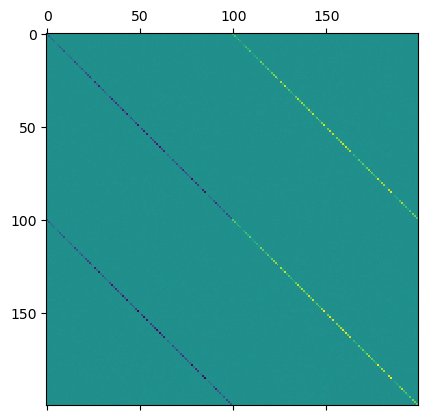

In [246]:
plt.matshow(tilde_v)